# Introduction to Earth Engine and TensorFlow in Cloud Datalab

This notebook walks you through a simple example of using Earth Engine and TensorFlow together in Cloud Datalab.

Specifically, we will train a neural network to recognize cloudy pixels in a Landsat scene. For this simple example we will use the output of the Fmask cloud detection algorithm as training data.

## Configure the Environment
We begin by importing a number of useful libraries.

In [1]:
import ee
from IPython import display
import math
from matplotlib import pyplot
import numpy
from osgeo import gdal
import tempfile
import tensorflow as tf
import urllib
import zipfile

Initialize the Earth Engine client. This assumes that you have already configured Earth Engine credentials in this Datalab instance. If not, see the "`Earth Engine Datalab Initialization.ipynb`" notebook.

In [2]:
ee.Initialize()

## Inspect the Input Data

Load a Landsat image with corresponding Fmask label data.

In [3]:
input_image = ee.Image('LANDSAT/LT5_L1T_TOA_FMASK/LT50100551998003CPE00')

Let's define a helper function to make it easier to print thumbnails of Earth Engine images. (We'll be adding a library with utility functions like this one to the Earth Engine Python SDK, but for now we can do it by hand.)

In [4]:
def print_image(image):
  display.display(display.Image(ee.data.getThumbnail({
      'image': image.serialize(),
      'dimensions': '360',
  })))

Now we can use our helper function to quickly visualize the image and label data. The Fmask values are:

0 | 1 | 2 | 3 | 4
:---:|:---:|:---:|:---:|:---:
Clear | Water | Shadow | Snow | Cloud

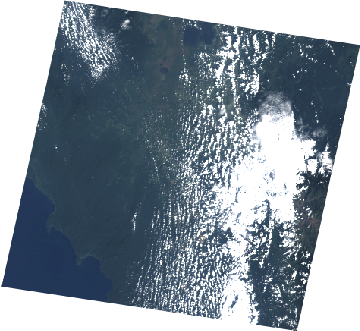

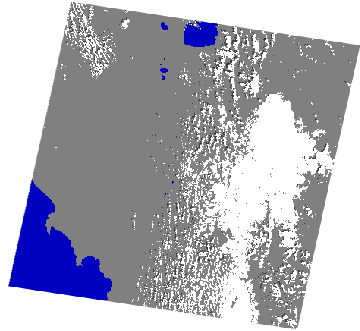

In [5]:
print_image(input_image.visualize(
    bands=['B3', 'B2', 'B1'],
    min=0,
    max=0.3,
))
print_image(input_image.visualize(
    bands=['fmask'],
    min=0,
    max=4,
    palette=['808080', '0000C0', '404040', '00FFFF', 'FFFFFF'],
))

## Fetch the Input Data

First we define some helper functions to download raw data from Earth Engine as `numpy` arrays.

We use the `getDownloadId()` function, which only works for modestly sized datasets. For larger datasets, a better approach would be to initiate a batch Export from Earth Engine to Cloud Storage, which you could easily manage right here in Datalab too.

In [6]:
import urllib.request

def download_tif(image, scale):
  url = ee.data.makeDownloadUrl(ee.data.getDownloadId({
        'image': image.serialize(),
        'scale': '%d' % scale,
        'filePerBand': 'false',
        'name': 'data',
  }))
  local_zip, headers = urllib.request.urlretrieve(url)
  with zipfile.ZipFile(local_zip) as local_zipfile:
    return local_zipfile.extract('data.tif', tempfile.mkdtemp())

def load_image(image, scale):
  local_tif_filename = download_tif(image, scale)
  dataset = gdal.Open(local_tif_filename, gdal.GA_ReadOnly)
  bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
  return numpy.stack(bands, 2)

Now we can use that function to load the data from Earth Engine, including a valid data band, as a `numpy` array. This may take a few seconds. We also convert the Fmask band  to a binary cloud label (i.e. `fmask`=4).

In [7]:
mask = input_image.mask().reduce('min')

data = load_image(input_image.addBands(mask), scale=240)

# Convert fmask band to boolean cloud mask
data[:,:,7] = numpy.equal(data[:,:,7], 4) 

Display the local data. This time, for variety, we display it as an NRG false-color image. We can use `pyplot` to display local `numpy` arrays.

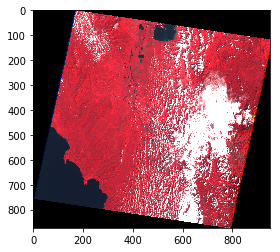

In [15]:
pyplot.imshow(numpy.clip(data[:,:,[3,2,1]] * 3, 0, 1))
pyplot.show()

## Preprocess the Input Data

Select the valid pixels and hold out a fraction for use as validation data.  Compute per-band means and standard deviations of the training data for normalization.

In [16]:
HOLDOUT_FRACTION = 0.1

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Select only the valid data and shuffle it.
valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
numpy.random.shuffle(valid_data)

# Hold out a fraction of the labeled data for validation.
training_size = int(valid_data.shape[0] * (1 - HOLDOUT_FRACTION))
training_data = valid_data[0:training_size,:]
validation_data = valid_data[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:7].mean(0)
data_std = training_data[:,0:7].std(0)

## Build the TensorFlow Model

We start with a helper function to build a simple TensorFlow neural network layer.

In [17]:
def make_nn_layer(input, output_size):
  input_size = input.get_shape().as_list()[1]
  weights = tf.Variable(tf.truncated_normal(
      [input_size, output_size],
      stddev=1.0 / math.sqrt(float(input_size))))
  biases = tf.Variable(tf.zeros([output_size]))
  return tf.matmul(input, weights) + biases

Here we define our TensorFlow model, a neural network with two hidden layers with tanh() nonlinearities. The main network has two outputs, continuous-valued “logits” representing non-cloud and cloud, respectively. The binary output is intepreted as the argmax of these outputs.

We define a training step, which uses Kingma and Ba's Adam algorithm to minimize the cross-entropy between the logits and the training data. Finally, we define a simple overall percentage accuracy measure.

In [18]:
NUM_INPUT_BANDS = 7
NUM_HIDDEN_1 = 20
NUM_HIDDEN_2 = 20
NUM_CLASSES = 2

input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
labels = tf.placeholder(tf.float32, shape=[None])

normalized = (input - data_mean) / data_std
hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2))
logits = make_nn_layer(hidden2, NUM_CLASSES)
outputs = tf.argmax(logits, 1)

int_labels = tf.to_int64(labels)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

correct_prediction = tf.equal(outputs, int_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train the Neural Network

Now train the neural network, using batches of training data drawn randomly from the training data pool. We periodically compute the accuracy against the validation data. When we're done training, we apply the model to the complete input data set.

This simple notebook performs all TensorFlow operations locally. However, for larger analyses you could bring up a cluster of TensorFlow workers to parallelize the computation, all controlled from within Datalab.

In [19]:
BATCH_SIZE = 1000
NUM_BATCHES = 1000

with tf.Session() as sess:
  sess.run(tf.initialize_all_variables())

  validation_dict = {
    input: validation_data[:,0:7],
    labels: validation_data[:,7],
  }

  for i in range(NUM_BATCHES):
    batch = training_data[numpy.random.choice(training_size, BATCH_SIZE, False),:]
    train_step.run({input: batch[:,0:7], labels: batch[:,7]})

    if i % 100 == 0 or i == NUM_BATCHES - 1:
      print('Accuracy %.2f%% at step %d' % (accuracy.eval(validation_dict) * 100, i))

  output_data = outputs.eval({input: data_vector[:,0:7]})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


InternalError: Blas GEMM launch failed : a.shape=(1000, 7), b.shape=(7, 20), m=1000, n=20, k=7
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](truediv, Variable/read)]]

Caused by op 'MatMul', defined at:
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 497, in start
    self.io_loop.start()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-11e7fcf4da6c>", line 10, in <module>
    hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
  File "<ipython-input-17-7b22b9d5e1e8>", line 7, in make_nn_layer
    return tf.matmul(input, weights) + biases
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2014, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4567, in mat_mul
    name=name)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(1000, 7), b.shape=(7, 20), m=1000, n=20, k=7
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](truediv, Variable/read)]]


## Inspect the Results

Here we dislay the results. The red band corresponds to the TensorFlow output and the blue band corresponds to the labeled training data, so pixels that are red and blue correspond to disagreements between the model and the training data. (There aren't many: look carefully around the fringes of the clouds.)

In [ ]:
output_image = output_data.reshape([data.shape[0], data.shape[1]])
red = numpy.where(data[:,:,8], output_image, 0.5)
blue = numpy.where(data[:,:,8], data[:,:,7], 0.5)
green = numpy.minimum(red, blue)

comparison_image = numpy.dstack((red, green, blue))
pyplot.figure(figsize = (12,12))
pyplot.imshow(comparison_image)
pyplot.show()

We can zoom in on a particular region over on the right side of the image to see some of the disagreements. Red pixels represent comission errors and blue pixels represent omission errors relative to the labeled input data.

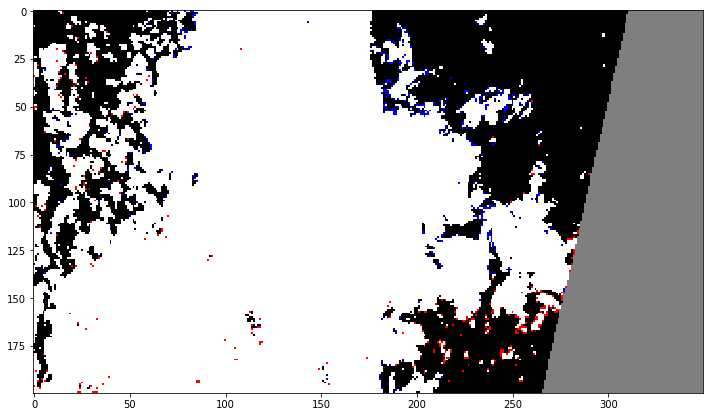

In [24]:
pyplot.figure(figsize = (12,12))
pyplot.imshow(comparison_image[300:500,600:,:], interpolation='nearest')
pyplot.show()